In [6]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.datasets import *
from fastai.vision import *
from fastai import *

import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import json



In [7]:
ROOT_PATH=Path('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/')
DATA_PATH=Path(ROOT_PATH/'data')
VOC_DEVKIT_PATH = Path(DATA_PATH/'VOCdevkit')
MODEL_PATH=Path(ROOT_PATH/'model')
TRAIN_PATH=Path(ROOT_PATH/'train')              
VOC_DEVKIT_PATH.ls()





[PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/pascal_val2007.json'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/.ipynb_checkpoints'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007'),
 PosixPath('/home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/pascal_train2007.json')]

In [8]:
train_json_path = Path(VOC_DEVKIT_PATH/'pascal_train2007.json')
with open(train_json_path, 'r') as f:
    train_json = json.loads(f.read())



In [15]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']

train_json[IMAGES][:5]




[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [16]:
train_json[ANNOTATIONS][:3]




[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0},
 {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]],
  'area': 81326,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [89, 77, 314, 259],
  'category_id': 13,
  'id': 3,
  'ignore': 0}]

In [17]:
train_json[CATEGORIES][:5]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'}]

### Create dict from id to category (dict[id] -> category)

In [10]:
categories = dict([(c['id'], c['name']) for c in train_json[CATEGORIES]])



### Create map of id to image file (dict[id] -> filename)

In [12]:
images = dict([(i['id'], i['file_name']) for i in train_json['images']])



### List of image ids

In [13]:
image_ids = [i['id'] for i in train_json['images']]



In [14]:
JPEGS_PATH = Path(VOC_DEVKIT_PATH/'VOC2007'/'JPEGImages')
IMAGES_PATH = JPEGS_PATH
JPEGS_PATH.ls()[:5]
train_json[ANNOTATIONS][:2]



[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

### Create a dict with image_id to bounding box and category dict[image_id] -> (bbox, category)


1. The goal here is to create a dictionary that maps an `image_id` to the `bbox` and `category`
2. This requires a few additional helper methods described below 

<br>

### Helper methods
<br>

1. The information in the `annotations` dictionary has an attribute called `bbox` which is represented in a notation usually used in ML, which is width by height whereas most libraries and math representation is width by height 

<br>

#### TLDR;
 - Math world - rows by columns (height by width)
 - Computer Vision  - columns by rows (width by height)

#### Changing BBOX representation format

In [99]:

def create_train_annotations(train_json:dict):
    """
    1. creates an annotations dictionary 
    2. converts the format in which height and width is stored in the 
    annotations dictionary of the train_json dict.
    3. Also converts the height and width information to top left x, y cordinate and bottom right x, y coordinate
    Hence the subtraction information
    """
    annotations = collections.defaultdict(lambda:[])
    for o in train_json[ANNOTATIONS]:
        bbox = o['bbox']
        bb = np.array([bbox[1], bbox[0], bbox[3]+bbox[1], bbox[2]+bbox[0]])
        annotations[o['image_id']].append((bb, o['category_id']))
    return annotations

def get_category(category_id): 
    cat = categories.get(category_id, None)
    if not cat: 
        cat = val_categories.get(category_id, None)
    return cat

def get_image_filename(image_id): 
    filename = images.get(image_id, None)
    if not filename:
        filename = val_images.get(image_id, None)
    return filename
        
def _get_annotations(image_id): 
    annot =  annotations.get(image_id, None)
    if not annot:
        annot = val_annotations.get(image_id, None)
    return annot


def convert_bb_to_height_and_width(bbox):
    """
    Does the opposite. 
    1. Converts bbox x, y coordinates for top left and bottom right to height and width information
    """
    bb = bbox
    return np.array([bb[1], bb[0], bb[3]-bb[1], bb[2]-bb[0]])

def _open_image(filename):
    """
    1. opens an image with just the filename using the standard `open_image` method
    """
    return open_image(JPEGS_PATH/filename)

def _display_with_bbox(img_filename, bbox:list=None):
    """
    1. Creates bounding boxes using FastAIs ImageBBox api
    """
    if isinstance(img_filename, str):
        img = _open_image(img_filename)
    else:
        img = img_filename
        
    if not isinstance(bbox, ImageBBox):        
        bb, category = bbox    
        category_name = category if isinstance(category, list) else get_category(category)
        img_bbox = ImageBBox.create(*img.size, bb, labels=[0], classes=list(category_name))        
    else:
        img_bbox = bbox
    img.show(y=img_bbox, figsize=(5, 5))
    
def _get_largest_img_bbox(img_annotation):
    if not img_annotation: raise Exception
    sorted_bbox = sorted(img_annotation, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return sorted_bbox[0]


def extract_filenames_and_categories(filename):    
    filenames, bbox_cat = get_annotations(VOC_DEVKIT_PATH/f'{filename}')
    bbox_cat = np.array(bbox_cat)
    cats = bbox_cat[:,1]
    extract_labels = lambda x: " ".join(x)
    categories = [extract_labels(set(cat_list)) for cat_list in cats]
    return pd.DataFrame({'filename': filenames, 'categories': categories})
    

In [120]:
train_df = extract_filenames_and_categories('pascal_train2007.json')
train_df['is_valid'] = 0
val_df = extract_filenames_and_categories('pascal_val2007.json')
val_df['is_valid'] = 1
df = train_df.append(val_df)

In [121]:
df.head()

,filename,categories,is_valid
0,000012.jpg,car,0
1,000017.jpg,horse person,0
2,000023.jpg,bicycle person,0
3,000026.jpg,car,0
4,000032.jpg,aeroplane person,0


In [291]:
data = ImageList.from_df(df, path=JPEGS_PATH)
data = data.split_by_rand_pct(valid_pct=0.4)
data = data.label_from_df(cols=['categories'], label_delim=' ')
data = data.transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), 
                      size=224)
data = data.databunch()
data = data.normalize(imagenet_stats)

In [292]:
data

ImageDataBunch;

Train: LabelList (3007 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
aeroplane,diningtable;person,dog,train,car;chair
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Valid: LabelList (2004 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
tvmonitor;chair;bottle;pottedplant;sofa,dog,diningtable;chair;person,cat,car;person
Path: /home/ec2-user/SageMaker/SingleShot_ObjectDetection/data/VOCdevkit/VOC2007/JPEGImages;

Test: None

In [307]:
t = torch.randn((64, 237))
# tt = torch.argmax(t, dim=1).float().cuda()


y_t = torch.tensor([206,   0, 163,  59,  77,  30, 206, 157,  87, 235, 158, 206, 163, 170,
         98,  26, 162,  26, 163,  87,  26,  35, 162, 112, 163, 163,  66, 206,
         95,   0,  53,  87,  30, 166, 171,  73,   0,   5, 141,  87, 141, 112,
          7,   5,   7, 231,  59, 223,  43, 141, 141,  59, 206, 163, 156,  44,
         87, 152,   0, 163,  77, 163,  35, 167], device='cuda:0')

# tt_t = tt.sigmoid()
# ((tt_t>0.2).byte==y_t.byte()).float()


In [306]:
# def accuracy_thresh(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, sigmoid:bool=True)->Rank0Tensor:
#     "Computes accuracy when `y_pred` and `y_true` are the same size."    
#     print(f'y_pred: {y_pred}, y_true: {y_true}')
#     if sigmoid: y_pred = torch.argmax(y_pred.sigmoid()).cuda()
#     print(f'y_pred: {y_pred.shape}, y_true: {y_true.shape}')
# #     if sigmoid: y_pred = y_pred.sigmoid()
#     return ((y_pred>thresh).byte()==y_true.byte()).float().mean()

accuracy_thresh.__module__
from fastai.metrics import accuracy_thresh

In [308]:
acc_02 =partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = None
learn = cnn_learner(data, models.resnet34, metrics=[acc_02])

In [309]:
learn.model


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [310]:
learn.data.classes

['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [311]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 2.51E-02


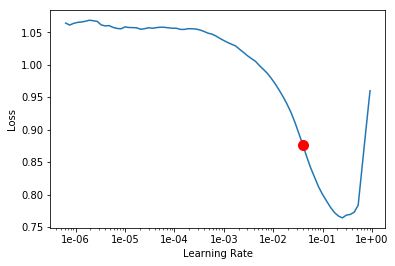

In [312]:
learn.recorder.plot(suggestion=True)

In [313]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.543621,0.125393,0.944486,00:32
1,0.238546,0.094890,0.957859,00:31
2,0.146151,0.090871,0.961851,00:31


In [314]:
learn.unfreeze()

In [315]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-06
Min loss divided by 10: 1.45E-06


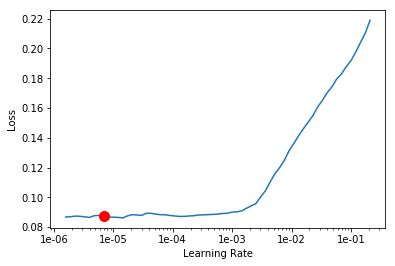

In [320]:
learn.recorder.plot(suggestion=True, skip_start=15)

In [ ]:
learn.fit_one_cycle(1, 8e-6)